# Evaluation notebook

Here, we will evaluate the relations extracted in all the other notebooks

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import cPickle
import numpy as np

# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')
sys.path.append('../src/crawler')

# set up paths
abstract_dir = '../data/db/papers'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load documents ids from paper/phenotype relation set.

In [4]:
pmids = list()
with open('results/nb-output/phenotypes.extracted.tsv') as f:
    for line in f:
        pmid, _ = line.strip().split('\t')
        pmids.append(pmid)
        
print len(pmids), 'paper ids loaded, e.g.:'
print pmids[:5]                           

589 paper ids loaded, e.g.:
['25086665', '23349640', '20436471', '24714607', '22174851']


## Loading results from other notebooks

We are going to collect the relations that have been extracted by the previous modules. 

The paths below point to pre-computed results; you will need to modify these paths to run them on your own input.

#### Phenotype/rsid relations from tables

In [5]:
phen_table_associations = dict()
with open('results/nb-output/phen-rsid.table.rel.all.tsv') as f:
    for line in f:
        fields = line.strip().split('\t')
        pmid, rsid, phen, pval, _, table_id, row_id, col_id = fields
        pval, table_id, row_id, col_id = float(pval), int(table_id), int(row_id), int(col_id)
        # note that we assume that an rsid at a givel location will correspond to 1 phenotype
        phen_table_associations[pmid, table_id, row_id, col_id] = (rsid, phen)
        
print len(phen_table_associations), 'loaded, e.g.:'
print phen_table_associations.items()[:5]

2156 loaded, e.g.:
[(('21738491', 1, 3, 2), ('rs12143842', 'QT')), (('17903301', 1, 55, 1), ('rs7544568', 'Aortic root diameter')), (('20585627', 2, 8, 1), ('rs12931267', 'Red hair')), (('17903306', 4, 31, 1), ('rs2195926', 'SDNN')), (('17903301', 2, 9, 1), ('rs10514431', 'left ventricular diastolic dimension'))]


#### PMID/Phenotype relations extracted from titles/abstracts

In [6]:
phen_text_associations = dict()
with open('results/nb-output/phenotypes.extracted.tsv') as f:
    for line in f:
        pmid, phen = line.strip().split('\t')
        phen_text_associations[pmid] = phen
        
print len(phen_text_associations), 'phenotypes loaded, e.g.:'
print phen_text_associations.items()[:5]                           

589 phenotypes loaded, e.g.:
[('23738518', 'Reading|Language'), ('22044751', 'Chronic Kidney Disease'), ('21298047', 'European-Origin|Substance Dependence'), ('23104006', 'Endometriosis'), ('20072603', 'Osteoporosis')]


#### RSID/Pvalue relations extracted from tables

In [12]:
pval_table_associations = dict()
with open('results/nb-output/supp-pval-rsid.filtered.tsv') as f:
    for line in f:
        pmid, rsid, table_id, row_id, col_id, pval = line.strip().split('\t')
        pval, table_id, row_id, col_id = float(pval), int(table_id), int(row_id), int(col_id)
        
        key = pmid, table_id, row_id, col_id, rsid
        if key not in pval_table_associations: pval_table_associations[key] = set()
        pval_table_associations[key].add(pval)

print len(pval_table_associations), 'relations loaded, e.g.:'
print pval_table_associations.items()[:5]      

23648 relations loaded, e.g.:
[(('23251661', 0, 185, 0, 'rs12479213'), set([-5.040959])), (('20339536', 3, 4, 0, 'rs16909449'), set([-5.920819])), (('20639881', 5, 12, 0, 'rs227418'), set([-4.421361, -3.806875, -4.326979])), (('23583980', 10, 52, 0, 'rs10518693'), set([-2.192465, -2.14752])), (('23251661', 0, 19, 0, 'rs6598955'), set([-5.458421]))]


#### Table annotations

In [8]:
non_gwas_tables = set()
with open('results/nb-output/table-annotations.tsv') as f:
    for line in f:
        pmid, table_id, pval_found, lod_found = line.strip().split('\t')
        if int(pval_found) or int(lod_found):
            non_gwas_tables.add((pmid, int(table_id)))
                                  
print len(non_gwas_tables), 'suspcious table ids loaded, e.g.:'
print list(non_gwas_tables)[:5]   

790 suspcious table ids loaded, e.g.:
[('21273288', 1), ('19343178', 1), ('23886662', 6), ('23028341', 2), ('23844046', 3)]


#### Singleton RSids

In [7]:
singleton_associations = dict()
with open('results/nb-output/rsids.singletons.all.tsv') as f:
    for line in f:
        pmid, table_id, row_id, col_id, rsid = line.strip().split()
        table_id, row_id, col_id = int(table_id), int(row_id), int(col_id)
        singleton_associations[pmid, table_id, row_id, col_id] = rsid

print len(singleton_associations), 'loaded, e.g.:'
print singleton_associations.items()[:5]

n_singletons_by_table = dict()
for (pmid, table_id, row_id, col_id), rsid in singleton_associations.items():
    key = pmid, table_id
    if key not in n_singletons_by_table: n_singletons_by_table[key] = 0
    n_singletons_by_table[key] += 1

12309 loaded, e.g.:
[(('20838585', 0, 18, 3), 'rs6829649'), (('23128233', 0, 17, 2), 'rs9264942'), (('23754948', 1, 6, 0), 'rs10478424'), (('25129146', 0, 8, 0), 'rs1642764'), (('17903301', 2, 9, 1), 'rs10514431')]


## Construct a list valid relations

Next, we combine all of the above relations into a single set of associations.

In [13]:
import re

def clean(phen):
    phen = re.sub('[)():.]+', '', phen)
    phen = re.sub('^or ', '', phen)
    phen = phen.strip()
    return phen

associations = []

tables_found = {(pmid, table_id) for pmid, table_id, _, _, _ in pval_table_associations} # with pvalues
# tables_found.update(non_gwas_tables)

# # record table associations wth all pval < 1e-5 or no pval reported
# chosen_rsids = set()
# for (pmid, table_id, row_id, col_id), (rsid, loc_phen) in phen_table_associations.items():
#     pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [])
#     glob_phen = clean(phen_text_associations[pmid])
#     if (pvals and 10**max(pvals) < 1e-5):
#         associations.append((pmid, rsid, (table_id, row_id, col_id), (glob_phen, loc_phen)))
#         chosen_rsids.add((pmid, table_id, row_id, col_id, rsid))


# record associations with no local phenotype
for (pmid, table_id, row_id, col_id, rsid), pvals in pval_table_associations.items():
    # skip low-pvalue snps and snps that we already added
    if pvals and 10**max(pvals) > 1e-5: continue
#     if (pmid, table_id, row_id, col_id, rsid) in chosen_rsids: continue
    
    # append with global phenotype
    phen = clean(phen_text_associations[pmid])
    associations.append((pmid, rsid, (table_id, row_id, col_id), (phen, '')))    
#     chosen_rsids.add((pmid, table_id, row_id, col_id, rsid))

# # record singletons
# n_singletons_added = 0
# for (pmid, table_id, row_id, col_id), rsid in singleton_associations.items():
#     if (pmid, table_id, row_id, col_id, rsid) in chosen_rsids: continue
#     if (pmid, table_id) in tables_found: continue
#     if n_singletons_by_table[(pmid, table_id)] < 30: continue
#     phen = clean(phen_text_associations[pmid])
#     associations.append((pmid, rsid, (table_id, row_id, col_id), (phen, ''))) 
#     n_singletons_added += 1

print len(associations), 'associations, e.g.:'
print associations[:5]    
# print 'There were %d singletons' % n_singletons_added

9611 associations, e.g.:
[('23251661', 'rs12479213', (0, 185, 0), ('Childhood Obesity|Childhood', '')), ('20339536', 'rs16909449', (3, 4, 0), ('Lipid-Lowering Response|Response Statins', '')), ('23251661', 'rs6598955', (0, 19, 0), ('Childhood Obesity|Childhood', '')), ('23817569', 'rs6906021', (0, 116, 0), ('Allergy', '')), ('23381943', 'rs10801560', (1, 132, 1), ('Ischemic Stroke', ''))]


These are the associations extracted by our system.

In [14]:
with open('results/supp-associations.tsv', 'w') as f:
    for (pmid, rsid, (table_id, row_id, col_id), (glob_phen, loc_phen)) in associations:
        pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [])
        pval = min(pvals) if pvals else -1000
        loc_phen = '-' if not loc_phen else loc_phen

        f.write('%s\t%s\t%s\t%s\t%f\n' % (pmid, rsid, glob_phen, loc_phen, pval))

We now proceed to evaluate these relations.

## Comparing to GWAS Central

First, we want to evalaute the recall relative to existing databases.

We start with GWAS Central, which is more extensive than GWAS Catalog (for papers up to ~2013), and which contains very precise phenotype labels.

In [15]:
from db.kb import KnowledgeBase

kb = KnowledgeBase()
assocs = [assoc for pmid in pmids for assoc in kb.assoc_by_pmid(pmid) if assoc.source == 'gwas_central' and assoc.pvalue < 1e-5]
# assocs = [assoc for pmid in pmids for assoc in kb.assoc_by_pmid(pmid) if assoc.source == 'gwas_central']

print '%d documents, %d associations' % (len(pmids), len(assocs))

589 documents, 1738 associations


### Set up map of GWC to GWASDB phenotypes

Because each database uses different words to describe phenotypes (words chosen by the human curators), we need a mapping between equivalent phenotype names.

In [11]:
# This cell records phenotypes associated with each (pmid, rsid) pair
# in both our relations and ones in GWC.

rel_dict = { (pmid, rsid) : set() for (pmid, rsid, _, _) in associations }
for (pmid, rsid, loc, phen) in associations:
    rel_dict[(pmid, rsid)].add(phen)

gold_rel_dict = { (a.paper.pubmed_id, a.snp.rs_id) : set() for a in assocs }
for a in assocs:
    gold_rel_dict[(a.paper.pubmed_id, a.snp.rs_id)].add(a.phenotype.name)

We generate a map of all potential matches. 

Phenotypes `p1`, `p2` could match if we find `(pmid, rsid, p1)` in GWC and
`(pmid, rsid, p2)` in our relations.

We save this to a file and manually specify if each `(p1, p2)` are 
equivalent. We can also load existing mappings via the `phen_scores` dict

In [12]:
out_set = set()
for a in assocs:
    s1 = gold_rel_dict[(a.paper.pubmed_id, a.snp.rs_id)]
    s2 = rel_dict.get((str(a.paper.pubmed_id), a.snp.rs_id), None)
    if s1 and s2:
        for name1 in s1:
            for name2a, name2b in s2:
                name1 = str(name1)
                try:
                    score = phen_scores.get((name1.lower(), name2a.lower(), name2b.lower()), '')
                except:
                    score = ''
                out_set.add('%s\t%s\t%s\t%s\n' % (name1, name2a, name2b, score))

with open('phenotype.mapping.tsv', 'w') as f:                    
    for out_str in out_set:
        f.write(out_str)

This loads our pre-annotated mapping of phenotypes.

Each pair of phenotypes has a score: 0: incorrect, 1: incorrect because acronym could not be resolve, 2: generally correct, but imprecise, 3: fully correct (at least as precise as the human-created label)

In [12]:
phen_map = dict()
phen_scores = dict()
with open('util/phenotype.mapping.annotated.tsv') as f:                    
    for line in f:
        fields = line.strip().split('\t')
        fields = [re.sub('"', '', f) for f in fields]
        orig_name, glob_name, loc_name, score = fields

        phen_scores[(orig_name.lower(), glob_name.lower(), loc_name.lower())] = score
        # change the tuple below to ('3',) in order to look at only maximally 
        # precise phenotypes
        if score in ('2', '3',):
            key = (glob_name, loc_name)
            if key not in phen_map: phen_map[key] = set()
            phen_map[key].add(orig_name) 

print 'Loaded mapping for %d relations.' % len(phen_map)

Loaded mapping for 490 relations.


### Look at recall relative to GWAS Central

We compute recall over the subset of "recoverable" relations, which are ones that are found in the paper XML body. The following function determines if an RSID is present anywhere in the paper.

In [13]:
import re

def paper_contains(pmid, quote):
    with open('../data/db/papers/%d.xml' % pmid) as f:
        txt = f.read()
        return True if re.search(quote, txt) else False

We now use our mapping to comapre against GWAS Central

In [14]:
confirmed_assocs_gwcen = list()

# display directly the results we found
n_correct, n_imprecise, n_missing, n_wrong, n_total, n_new = 0, 0, 0, 0, 0, 0
invalid_per_paper = { a.paper.pubmed_id : 0 for a in assocs }
seen = set()
for a in assocs:
    if (a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name) in seen: continue
    seen.add((a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name))
    
    gold_phen_set = {a.phenotype.name} # gwc phenotype string
    # load the set of gwasdb phenotypes to which the snp was mapped in this paper
    pred_phen_set = rel_dict.get((str(a.paper.pubmed_id), a.snp.rs_id), {}) 
    # translate these phenotypes into gwc phenotypes using our map
    pred_phen_transl_set = {m for p in pred_phen_set for m in phen_map.get(p, {})}

    if gold_phen_set & pred_phen_transl_set: 
        n_correct += 1
        n_total += 1
        # record the corresponding gwasdb associations as having been correctly recovered
        correct_phenotypes = [p for p in pred_phen_set if phen_map.get(p, set()) & gold_phen_set]
        for p in correct_phenotypes:
            confirmed_assocs_gwcen.append( (str(a.paper.pubmed_id), a.snp.rs_id, p) )
    else:
        if paper_contains(a.paper.pubmed_id, a.snp.rs_id):
            # this can be used to diagnose errors
            if a.paper.pubmed_id == 888:
                # print phenotypes
                print a.snp.rs_id, gold_phen_set, pred_phen_set, pred_phen_transl_set
            if pred_phen_set:
                n_wrong += 1
            else:
                n_missing += 1
            n_total += 1
            invalid_per_paper[a.paper.pubmed_id] += 1

print 'Correctly identifed relations:', n_correct
print 'Incorrectly identifed b/c of wrong phenotype:', n_wrong
print 'Relations not found at all:', n_missing
print 'Total relations in GWC:', n_total

print 'Papers with most missed relations:', sorted(invalid_per_paper.items(), key=lambda x: x[1], reverse=True)[:10]

Correctly identifed relations: 2448
Incorrectly identifed b/c of wrong phenotype: 69
Relations not found at all: 491
Total relations in GWC: 3008
Papers with most missed relations: [(17903301, 18), (17903305, 17), (19197348, 16), (18159244, 15), (23400010, 14), (21810271, 11), (24121790, 10), (24058526, 10), (22747683, 9), (22216198, 8)]


## Comparison to GWAS Catalog

Next, we repeat the same analysis with GWAS Catalog relations.

GWAS Catalog uses less precise phenotypes, but contains many recent papers that are not in GWAS Central.

In [15]:
from db.kb import KnowledgeBase

kb = KnowledgeBase()
assocs = [assoc for pmid in pmids for assoc in kb.assoc_by_pmid(pmid) if assoc.source == 'gwas_catalog' and assoc.pvalue < 1e-5]

print '%d documents, %d associations' % (len(pmids), len(assocs))

589 documents, 9747 associations


### Set up map of GWASdb to GWASCat phenotypes

We set up a phenotype map in the same way as above

In [16]:
rel_dict = { (pmid, rsid) : set() for (pmid, rsid, _, _) in associations }
for (pmid, rsid, loc, phen) in associations:
    rel_dict[(pmid, rsid)].add(phen)

gold_rel_dict = { (a.paper.pubmed_id, a.snp.rs_id) : set() for a in assocs }
for a in assocs:
    gold_rel_dict[(a.paper.pubmed_id, a.snp.rs_id)].add(a.phenotype.name)

In [18]:
out_set = set()
for a in assocs:
    s1 = gold_rel_dict[(a.paper.pubmed_id, a.snp.rs_id)]
    s2 = rel_dict.get((str(a.paper.pubmed_id), a.snp.rs_id), None)
    if s1 and s2:
        for name1 in s1:
            for name2a, name2b in s2:
                name1 = str(name1)
                score = phen_scores.get((name1.lower(), name2a.lower(), name2b.lower()), '')
                out_set.add('%s\t%s\t%s\t%s\n' % (name1, name2a, name2b, score))

with open('phenotype.mapping.gwascat.tsv', 'w') as f:                    
    for out_str in out_set:
        f.write(out_str)

We load pre-labeled annotations.

In [17]:
phen_map = dict()
phen_scores = dict()
with open('util/phenotype.mapping.gwascat.annotated.tsv') as f:                    
    for line in f:
        fields = line.strip().split('\t')
        fields = [re.sub('"', '', f) for f in fields]
        orig_name, glob_name, loc_name, score = fields

        phen_scores[(orig_name.lower(), glob_name.lower(), loc_name.lower())] = score
        # change the tuple below to ('3',) in order to look at only maximally 
        # precise phenotypes
        if score in ('2', '3',):
            key = (glob_name, loc_name)
            if key not in phen_map: phen_map[key] = set()
            phen_map[key].add(orig_name) 

print 'Loaded mapping for %d relations.' % len(phen_map)            

Loaded mapping for 609 relations.


### Recall relative to GWAS Catalog

In [18]:
confirmed_assocs_gwcat = list()

# display directly the results we found
n_correct, n_imprecise, n_missing, n_wrong, n_total, n_new = 0, 0, 0, 0, 0, 0
invalid_per_paper = { a.paper.pubmed_id : 0 for a in assocs }
seen = set()
for a in assocs:
    if (a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name) in seen: continue
    seen.add((a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name))
    
    gold_phen_set = {a.phenotype.name} # gwc phenotype string
    # load the set of gwasdb phenotypes to which the snp was mapped in this paper
    pred_phen_set = rel_dict.get((str(a.paper.pubmed_id), a.snp.rs_id), {}) 
    # translate these phenotypes into gwc phenotypes using our map
    pred_phen_transl_set = {m for p in pred_phen_set for m in phen_map.get(p, {})}

    if gold_phen_set & pred_phen_transl_set: 
        n_correct += 1
        n_total += 1
        # record the corresponding gwasdb associations as having been correctly recovered
        correct_phenotypes = [p for p in pred_phen_set if phen_map.get(p, set()) & gold_phen_set]
        for p in correct_phenotypes:
            confirmed_assocs_gwcat.append( (str(a.paper.pubmed_id), a.snp.rs_id, p) )
        
    else:
        if paper_contains(a.paper.pubmed_id, a.snp.rs_id):
            if a.paper.pubmed_id == 25133637:
                print a.snp.rs_id, gold_phen_set, pred_phen_set, pred_phen_transl_set
            if pred_phen_set:
                n_wrong += 1
            else:
                n_missing += 1
            n_total += 1
            invalid_per_paper[a.paper.pubmed_id] += 1

print n_correct, n_wrong, n_missing, n_total

print 'Biggest omissions:', sorted(invalid_per_paper.items(), key=lambda x: x[1], reverse=True)[:15]

rs1426654 set([u'body mass index']) {} set([])
rs10041997 set([u'body mass index (change over time)']) {} set([])
rs1347155 set([u'body mass index (change over time)']) {} set([])
rs7565158 set([u'body mass index (change over time)']) {} set([])
rs6447650 set([u'body mass index (change over time)']) {} set([])
rs347313 set([u'body mass index (change over time)']) {} set([])
rs8042988 set([u'height']) {} set([])
rs4898878 set([u'height']) {} set([])
rs1331623 set([u'height']) {} set([])
rs12882679 set([u'underweight status']) {} set([])
rs6833159 set([u'underweight status']) {} set([])
rs1475010 set([u'overweight status']) {} set([])
rs12101726 set([u'overweight status']) {} set([])
rs1161397 set([u'overweight status']) {} set([])
rs955423 set([u'body mass index']) {} set([])
rs3096490 set([u'body mass index']) {} set([])
3232 101 690 4023
Biggest omissions: [(25742292, 18), (19197348, 17), (25133637, 16), (24625756, 14), (23400010, 14), (17903305, 14), (24483146, 13), (21810271, 11), (

## Manually evaluating precision

We measure precision over associations that haven't been confirmed by either GWAS Catalog or GWAS Central.

In [19]:
assocs_gwdb = set([(pmid, rsid, phen) for pmid, rsid, _, phen in associations])
print 'Relations in GWASdb: %d' % len(assocs_gwdb)

confirmed_assocs_gwcen, confirmed_assocs_gwcat = set(confirmed_assocs_gwcen), set(confirmed_assocs_gwcat)
print 'Relations confirmed via GWAS Central: %d' % len(confirmed_assocs_gwcen)
print 'Relations confirmed via GWAS Catalog: %d' % len(confirmed_assocs_gwcat)

confirmed_assocs = (assocs_gwdb & set(confirmed_assocs_gwcen)) | (assocs_gwdb & set(confirmed_assocs_gwcat))
unconfirmed_assocs = assocs_gwdb - confirmed_assocs

print 'Relations confirmed via at least one database: %d' % len(confirmed_assocs)
print 'Unconfirmed assocs: %d' % len(unconfirmed_assocs)

Relations in GWASdb: 6376
Relations confirmed via GWAS Central: 2438
Relations confirmed via GWAS Catalog: 3235
Relations confirmed via at least one database: 3452
Unconfirmed assocs: 2924


Let's write down the confimred and unconfirmed associations that we found.

In [39]:
with open('results/associations.new.tsv', 'w') as f: 
    for (pmid, rsid, (table_id, row_id, col_id), (loc_phen, glob_phen)) in sorted(associations):
        if (pmid, rsid, (loc_phen, glob_phen)) in unconfirmed_assocs:
            pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [])
            pval = min(pvals) if pvals else -1000
            loc_phen = '-' if not loc_phen else loc_phen
            f.write('%s\t%s\t%s\t%s\t%f\n' % (pmid, rsid, loc_phen, glob_phen, pval))
    
with open('results/associations.known.tsv', 'w') as f:
    for (pmid, rsid, (table_id, row_id, col_id), (loc_phen, glob_phen)) in sorted(associations):
        if (pmid, rsid, (loc_phen, glob_phen)) in confirmed_assocs:
            pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [])
            pval = min(pvals) if pvals else -1000
            loc_phen = '-' if not loc_phen else loc_phen
            f.write('%s\t%s\t%s\t%s\t%f\n' % (pmid, rsid, loc_phen, glob_phen, pval))

We are also going to store all the associations found in GWAS Catalog and GWAS Central in a file.

In [40]:
gwcat_assocs = [assoc for pmid in pmids for assoc in kb.assoc_by_pmid(pmid) if assoc.source == 'gwas_catalog' and assoc.pvalue < 1e-5]
gwcen_assocs = [assoc for pmid in pmids for assoc in kb.assoc_by_pmid(pmid) if assoc.source == 'gwas_central' and assoc.pvalue < 1e-5]

with open('util/associations.gwcat.tsv', 'w') as f:
    for a in gwcat_assocs:
        f.write('%s\t%s\t%s\t%f\n' % (a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name, np.log(a.pvalue)))
        
with open('util/associations.gwcen.tsv', 'w') as f:
    for a in gwcen_assocs:
        f.write('%s\t%s\t%s\t%f\n' % (a.paper.pubmed_id, a.snp.rs_id, a.phenotype.name, np.log(a.pvalue)))        

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


In order to inverstigate the validity of the new relations that we found, we are going to sample 100 random relations and later ask independent annotators to verify them.

In [20]:
import random 
U = list(unconfirmed_assocs)
random.shuffle(U)
random_subset = list(U[:100])
random_subset = sorted(random_subset)
if False: # write random subset
    with open('rels.discovered.tsv', 'w') as f:
        for pmid, rsid, (glob_phen, loc_phen) in random_subset:
    #         print pmid, rsid, (glob_phen, loc_phen)
            f.write('%s\t%s\t%s\t%s\n' % (pmid, rsid, glob_phen, loc_phen) )

## Look at statistics of GWAS Catalog and GWAS Central

In [22]:
from db.kb import KnowledgeBase

# load all the associations in each database
kb = KnowledgeBase()
gwcen_a = set([(str(a.paper.pubmed_id), a.snp.rs_id, a.phenotype.name) for pmid in pmids for a in kb.assoc_by_pmid(pmid) if a.source == 'gwas_central' and a.pvalue < 1e-5])
gwcat_a = [(str(a.paper.pubmed_id), a.snp.rs_id, a.phenotype.name) for pmid in pmids for a in kb.assoc_by_pmid(pmid) if a.source == 'gwas_catalog' and a.pvalue < 1e-5]

# how many of these documents were actually in GWAS Central?
gwcen_papers = set([a[0] for a in gwcen_a])

print 'Searching over %d documents' % len(pmids)
print 'Of these, %d are in GWAS Central' % len(gwcen_papers)
print
print 'GWAS Central has %d associations' % len(gwcen_a)
print 'GWAS Catalog has %d associations' % len(gwcat_a)
print 'GWASdb has %d associations' % len(associations)
print

# we can't compare them directly, because phenotypes don't match; insteal we look at (pmid, rsid) tuples
gwcen_t = set([ (a[0], a[1]) for a in gwcen_a ])
gwcat_t = set([ (a[0], a[1]) for a in gwcat_a ])
gwdb_t = set([ (pmid, rsid) for pmid, rsid, _, _ in associations ])

print 'GWAS Central has %d significant variant tuples' % len(gwcen_t)
print 'GWAS Catalog has %d significant variant tuples' % len(gwcat_t)
print 'GWASdb has %d significant variant tuples' % len(gwdb_t)
print

# how many of these are unique to each database
all_t = gwcen_t | gwcat_t | gwdb_t
gwcen_t_uq = gwcen_t - gwcat_t - gwdb_t
gwcat_t_uq = gwcat_t - gwcen_t - gwdb_t
gwdb_t_uq = gwdb_t - gwcen_t - gwcat_t

print 'GWAS Central has %d unique significant variant tuples' % len(gwcen_t_uq)
print 'GWAS Catalog has %d unique significant variant tuples' % len(gwcat_t_uq)
print 'GWASdb has %d unique significant variant tuples' % len(gwdb_t_uq)

Searching over 589 documents
Of these, 430 are in GWAS Central

GWAS Central has 6086 associations
GWAS Catalog has 9747 associations
GWASdb has 7241 associations

GWAS Central has 5914 significant variant tuples
GWAS Catalog has 8384 significant variant tuples
GWASdb has 6187 significant variant tuples

GWAS Central has 371 unique significant variant tuples
GWAS Catalog has 2046 unique significant variant tuples
GWASdb has 2788 unique significant variant tuples


## Storing associations in a SQL database

Finally, in many applications it is preferrable to have the GWAS associations in the form of the structured database. We generate such associations here.

We start by defining a few helpers.

In [27]:
import unicodedata
def normalize_str(s):
    s = s.decode('utf-8')
    return unicodedata.normalize('NFKD', s).encode('ascii','ignore')

### Storing phenotypes

The format for the phenotype name is: `keyword1|keyword2|...|keywordn(\\local_phenotype)`, where the first set of keyword refer to the global phenotype, and the `local_phenotype` is omitted when it is not available (hence we put it in parantheses).

In [28]:
from db import db_session
from db.schema import *

# this assumes that the cells in the first part of the notebook have been executed
phen_dict = dict()
for (pmid, rsid, (table_id, row_id, col_id), (glob_phen, loc_phen)) in associations:
    name = glob_phen + '\\\\' + loc_phen if loc_phen else glob_phen
    name = normalize_str(name)
    key = name.lower()
    if key not in phen_dict:
        phenotype = Phenotype(name=name, source='gwasdb')      
        db_session.add(phenotype)
        db_session.commit()
        phen_dict[key] = phenotype

### Storing SNPs

In [29]:
from db import db_session
from db.schema import *

for (pmid, rsid, (table_id, row_id, col_id), (glob_phen, loc_phen)) in associations:
    snp = db_session.query(SNP).filter(SNP.rs_id==rsid).first()
    if not snp:
        snp = SNP(rs_id=rsid)
        db_session.add(snp)
        db_session.commit()

### Storing associations

In [33]:
from db import db_session
from db.schema import *

for (pmid, rsid, location, (glob_phen, loc_phen)) in associations:
    # retrieve phenotype
    name = glob_phen + '\\\\' + loc_phen if loc_phen else glob_phen
    name = normalize_str(name)
    key = name.lower()
    phenotype = phen_dict[key]
    
    # retrieve SNP
    snp = db_session.query(SNP).filter(SNP.rs_id==rsid).first()
    
    # retrieve paper
    paper = db_session.query(Paper).filter(Paper.pubmed_id==pmid).first()
    
    # retrieve p-value
    pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [None])
    
    # we will store the location in the 'description' field as table_id|row_id|col_id
    loc_str = '%d|%d|%d' % location
    
    # we create one association for each p-value associated with this SNP
    for pval in pvals:
        db_session.add(Association(
            snp=snp,
            phenotype=phenotype,
            paper=paper,
            pvalue=10**pval if pval else None,
            source='gwasdb',
            description=loc_str
          ))

db_session.commit()

## Visualizing the associations

We are going to first plot the distribution of pvalues for confirmed vs. newly-discoreved variants.

In [73]:
old_pvals, new_pvals = list(), list()
for (pmid, rsid, (table_id, row_id, col_id), (glob_phen, loc_phen)) in associations:
        pvals = pval_table_associations.get((pmid, table_id, row_id, col_id, rsid), [])
        if not pvals: continue
        if (pmid, rsid) in gwcen_t or (pmid, rsid) in gwcat_t:
            old_pvals.append(min(pvals))
#             old_pvals.extend((pvals))
        else:
            new_pvals.append(min(pvals))
#             new_pvals.extend((pvals))
print len(old_pvals), len(new_pvals)

3744 2917


In [25]:
import numpy as np 
from matplotlib import pyplot as plt
import scipy.stats as stats

stats.probplot([np.exp(p) for p in old_pvals], plot=plt)
# plt.show()

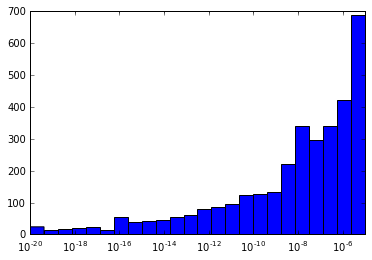

In [75]:
from matplotlib import pyplot as plt

plt.hist([10**(p) for p in old_pvals], bins=np.logspace(-20, -5, 25))
plt.gca().set_xscale("log")
# plt.ylim(0,900)
plt.show()

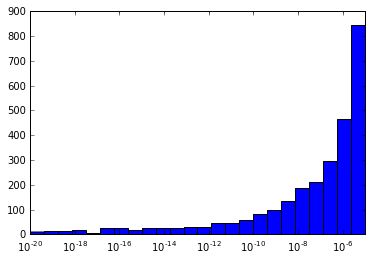

In [77]:
plt.hist([10**(p) for p in new_pvals], bins=np.logspace(-20, -5, 25))
plt.gca().set_xscale("log")
# plt.ylim(0,500)
plt.show()